In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## FIFA dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

### dataset loading and cleaning

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
for col in data_df.columns:
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [10]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Target = positions 

In [11]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [12]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


### Data spliting and scalling

In [13]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

X = data_df.drop('Position',axis=1)
y = data_df['Position']

# splitting in train ans test datasets
X_train, X_test , y_train, y_test= train_test_split(X,y,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [14]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Creating models2 ways

In [15]:
##### Calling class sequential and pass layers as a list
model =tf.keras.models.Sequential([
    tf.keras.layers.Dense(18, activation=tf.nn.silu),
    tf.keras.layers.Dense(4) #### no softmax activation function applied as np.exp(num>709) gives error 
    #### tensorflow uses internal function to handle such cases
])

In [16]:
#### defining all layes with inputs and creating a model with inputs and outputs
inputs = tf.keras.Input(shape = (33,))
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(4)(x)
model1 = tf.keras.Model(inputs = inputs, outputs = outputs)

In [17]:
### loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Checking if model and model1 are working properly

## model

For each example the model returns a vector of 'logits' or 'log-odds' scores, one for each class.

In [18]:
y_train[:1]

14537    3
Name: Position, dtype: int8

In [19]:
X_train[:1].shape  ### passing data as matrix

(1, 33)

In [20]:
### predict using model
predictions = model(X_train[:1]).numpy()
predictions

array([[ 0.7454056, -0.6074243, -0.5584018,  0.7429534]], dtype=float32)

In [21]:
## probabilities for each class for X_train[0]
tf.nn.softmax(predictions).numpy()

array([[0.39563933, 0.1022758 , 0.10741453, 0.39467034]], dtype=float32)

In [22]:
### calculate loss for model
loss_fn(y_train[:1],predictions).numpy()

0.9297044

## model1

In [23]:
### probabilities sum is ~ 1
tf.nn.softmax(predictions).numpy().sum()

1.0

In [24]:
### predict using model1
predictions1 = model1(X_train[:1]).numpy()
predictions1

array([[-1.03659   , -0.8093229 ,  0.01360038, -0.6567452 ]],
      dtype=float32)

In [25]:
### probabilities sum is ~ 1
tf.nn.softmax(predictions1).numpy().sum()

0.99999994

In [26]:
### calculate loss for model1
loss_fn(y_train[:1],predictions).numpy()

0.9297044

## Model summary

In [27]:
### model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
### model summary
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 18)                612       
                                                                 
 dense_3 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Limits of any exponential function (sigmoid, softmax, tanh, etc.)

In [29]:
sys.float_info.max                                                                                                                            

1.7976931348623157e+308

In [30]:
sys.float_info.min 

2.2250738585072014e-308

In [31]:
np.log(sys.float_info.max)

709.782712893384

In [32]:
np.exp(710)

C:\Users\Administrator.DAI-PC2\AppData\Local\Temp\ipykernel_34452\574927170.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(710)


inf

## Compiling and fitting model and model1

In [33]:
### compiling model
model.compile(optimizer = 'adam',loss = loss_fn, metrics = ['accuracy'])

### fiting model for training data 
history = model.fit(X_train,y_train, validation_data = [X_test,y_test],batch_size=BATCH_SIZE, epochs = EPOCHS)


Epoch 1/101


454/454 [==============================] - 3s 4ms/step - loss: 0.5571 - accuracy: 0.7840 - val_loss: 0.3765 - val_accuracy: 0.8388
Epoch 2/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3410 - accuracy: 0.8631 - val_loss: 0.3319 - val_accuracy: 0.8587
Epoch 3/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3160 - accuracy: 0.8714 - val_loss: 0.3185 - val_accuracy: 0.8667
Epoch 4/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3058 - accuracy: 0.8735 - val_loss: 0.3094 - val_accuracy: 0.8700
Epoch 5/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2991 - accuracy: 0.8768 - val_loss: 0.3068 - val_accuracy: 0.8683
Epoch 6/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2952 - accuracy: 0.8783 - val_loss: 0.3041 - val_accuracy: 0.8722
Epoch 7/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2924 - accuracy: 0.8791 - val_loss: 0.3004 - val_accuracy: 0.8

454/454 [==============================] - 1s 3ms/step - loss: 0.2666 - accuracy: 0.8932 - val_loss: 0.2951 - val_accuracy: 0.8769
Epoch 54/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2667 - accuracy: 0.8915 - val_loss: 0.2969 - val_accuracy: 0.8747
Epoch 55/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2659 - accuracy: 0.8910 - val_loss: 0.2988 - val_accuracy: 0.8763
Epoch 56/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2662 - accuracy: 0.8916 - val_loss: 0.2958 - val_accuracy: 0.8730
Epoch 57/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2659 - accuracy: 0.8907 - val_loss: 0.2994 - val_accuracy: 0.8760
Epoch 58/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2655 - accuracy: 0.8921 - val_loss: 0.2980 - val_accuracy: 0.8758
Epoch 59/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.8923 - val_loss: 0.2973 - val_accuracy: 0.8755
Epoch

In [34]:
### compiling model
model1.compile(optimizer = 'adam',loss = loss_fn, metrics = ['accuracy'])

### fiting model for training data 
history1 = model1.fit(X_train,y_train, validation_data = [X_test,y_test],batch_size=BATCH_SIZE, epochs = EPOCHS)

Epoch 1/101
454/454 [==============================] - 2s 3ms/step - loss: 0.6176 - accuracy: 0.7519 - val_loss: 0.3969 - val_accuracy: 0.8259
Epoch 2/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3585 - accuracy: 0.8497 - val_loss: 0.3418 - val_accuracy: 0.8471
Epoch 3/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3266 - accuracy: 0.8650 - val_loss: 0.3230 - val_accuracy: 0.8601
Epoch 4/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3128 - accuracy: 0.8713 - val_loss: 0.3133 - val_accuracy: 0.8650
Epoch 5/101
454/454 [==============================] - 1s 2ms/step - loss: 0.3045 - accuracy: 0.8744 - val_loss: 0.3091 - val_accuracy: 0.8656
Epoch 6/101
454/454 [==============================] - 1s 2ms/step - loss: 0.3003 - accuracy: 0.8759 - val_loss: 0.3068 - val_accuracy: 0.8678
Epoch 7/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2952 - accuracy: 0.8783 - val_loss: 0.3075 - val_accuracy: 0.8645

Epoch 58/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2615 - accuracy: 0.8916 - val_loss: 0.2985 - val_accuracy: 0.8813
Epoch 59/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2614 - accuracy: 0.8923 - val_loss: 0.3035 - val_accuracy: 0.8755
Epoch 60/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2611 - accuracy: 0.8927 - val_loss: 0.2979 - val_accuracy: 0.8818
Epoch 61/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2607 - accuracy: 0.8920 - val_loss: 0.2991 - val_accuracy: 0.8791
Epoch 62/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2605 - accuracy: 0.8926 - val_loss: 0.3011 - val_accuracy: 0.8777
Epoch 63/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2607 - accuracy: 0.8921 - val_loss: 0.3000 - val_accuracy: 0.8815
Epoch 64/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2599 - accuracy: 0.8919 - val_loss: 0.3012 - val_accuracy:

## Visualization

## model

In [37]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.557062,0.783977,0.376549,0.838843
1,0.340974,0.863126,0.331947,0.858678
2,0.315961,0.871392,0.318493,0.866667
3,0.305763,0.873528,0.309423,0.869972
4,0.299105,0.876834,0.306840,0.868320


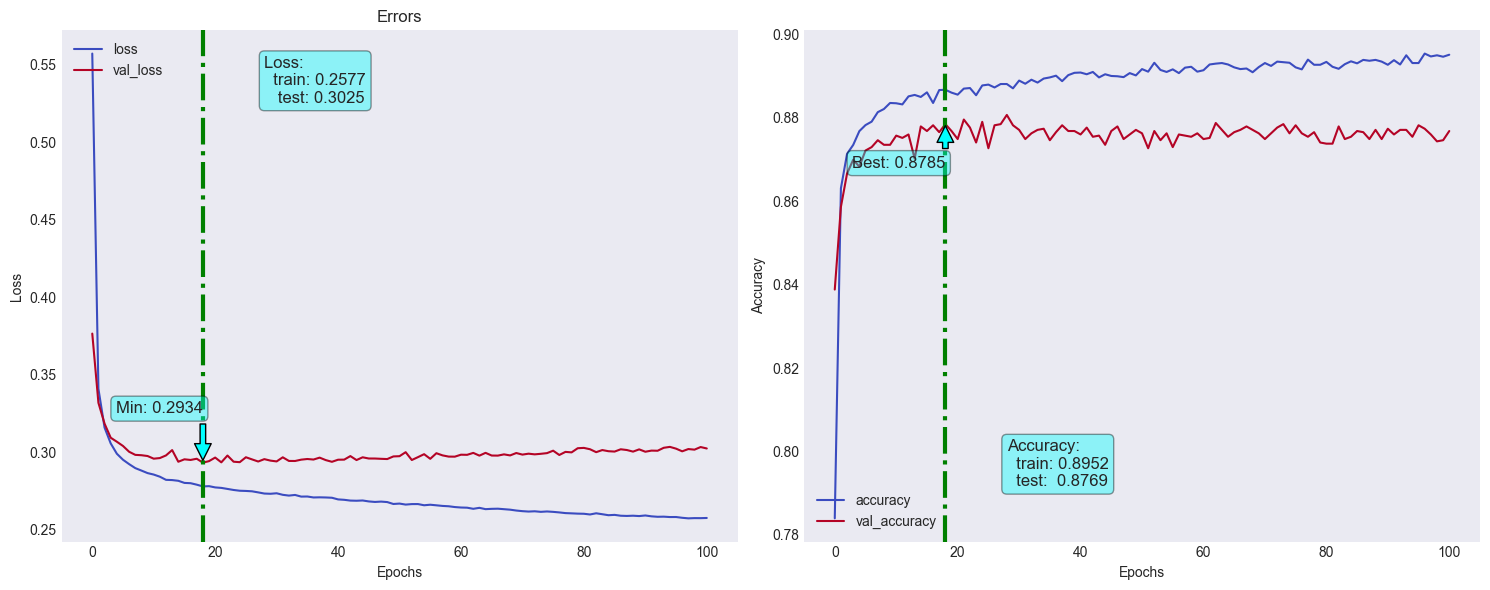

In [38]:
fn_plot_tf_hist(loss_df)

## model1

In [39]:
loss_df1 = pd.DataFrame(history1.history)
loss_df1.head()

,loss,accuracy,val_loss,val_accuracy
0,0.617584,0.751946,0.396876,0.825895
1,0.358496,0.849693,0.341821,0.847107
2,0.326620,0.864986,0.322965,0.860055
3,0.312845,0.871323,0.313329,0.865014
4,0.304508,0.874423,0.309129,0.865565


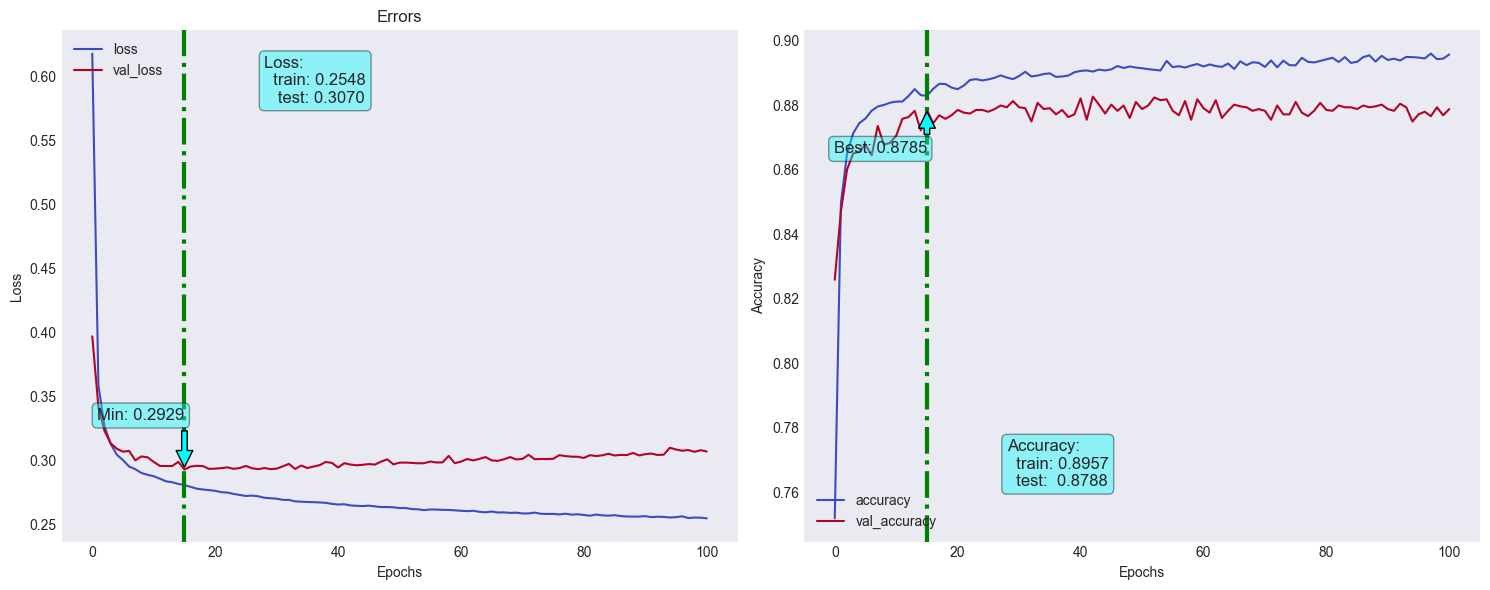

In [40]:
fn_plot_tf_hist(loss_df1)

## Predictions

### model

In [47]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

In [50]:
y_pred = probability_model(X_test).numpy()
y_pred.shape

(3630, 4)

In [57]:
print(classification_report(y_test,y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.92      1173
           2       0.83      0.85      0.84      1368
           3       0.82      0.76      0.79       684

    accuracy                           0.88      3630
   macro avg       0.89      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



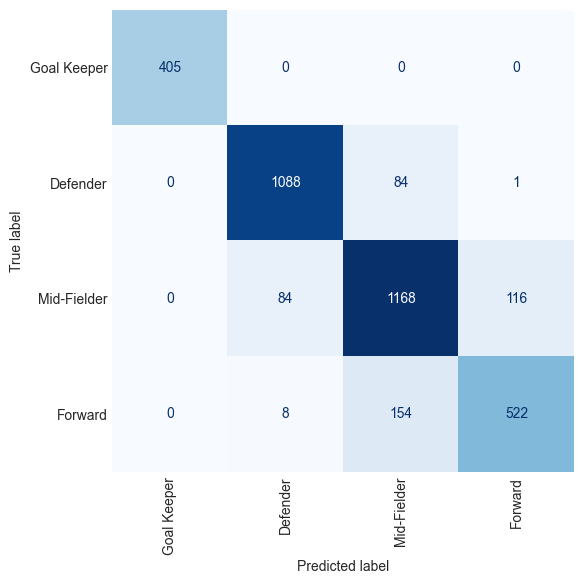

In [51]:
fn_plot_confusion_matrix(y_test,y_pred.argmax(axis=1),labels = labels)

### model1

In [52]:
probability_model1 = tf.keras.Sequential([model1,tf.keras.layers.Softmax()])

In [53]:
y_pred1 = probability_model1(X_test).numpy()
y_pred1

array([[1.7166337e-18, 3.2939300e-07, 5.1644516e-01, 4.8355454e-01],
       [3.1631641e-17, 3.3737319e-07, 6.4525253e-01, 3.5474709e-01],
       [2.7311795e-09, 7.2912674e-04, 5.7296956e-01, 4.2630127e-01],
       ...,
       [2.2101270e-12, 2.5785046e-02, 9.5264590e-01, 2.1569112e-02],
       [2.2695162e-20, 6.9379988e-05, 9.8977637e-01, 1.0154244e-02],
       [7.4937802e-25, 5.1627123e-01, 4.8370874e-01, 2.0006681e-05]],
      dtype=float32)

In [58]:
print(classification_report(y_test,y_pred1.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.93      1173
           2       0.84      0.85      0.84      1368
           3       0.81      0.78      0.79       684

    accuracy                           0.88      3630
   macro avg       0.89      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



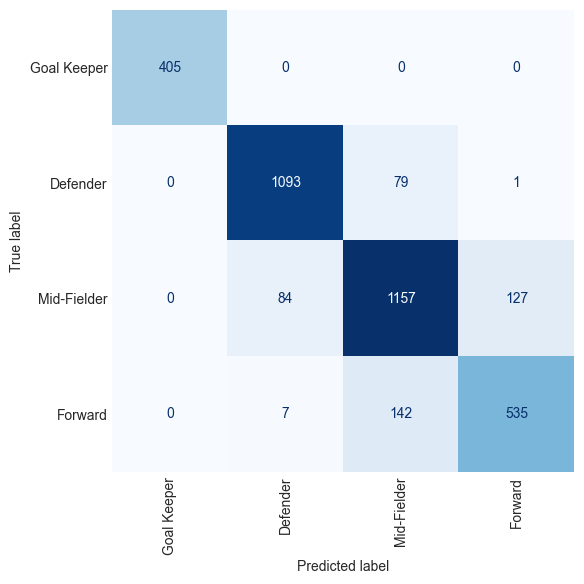

In [54]:
fn_plot_confusion_matrix(y_test,y_pred1.argmax(axis=1),labels = labels)